# Gaussian Scale Space

## Introduction

In this homework, we'll explore Gaussian Scale Space (GSS), a fundamental concept in computer vision that helps us analyze images at multiple scales. GSS is crucial for scale-invariant feature detection and forms the basis for many modern computer vision algorithms like SIFT.

## Prerequisites
First, let's import our required libraries:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.ndimage import gaussian_filter

## Part 1: Building the Scale Space

### 1.1 Basic Gaussian Blur Function
Let's start with the fundamental operation in scale space construction:


In [2]:
def gaussian_blur(img: np.ndarray, sigma: float) -> np.ndarray:
    """
    Apply Gaussian blur to an image with specified sigma.
    
    Args:
        img: Input image (grayscale or color)
        sigma: Standard deviation of the Gaussian kernel
        
    Returns:
        np.ndarray: Blurred image
    """
    return gaussian_filter(img, sigma=sigma)

### 1.2 Scale Space Generation
Now let's implement the complete scale space:

In [3]:
def create_scale_space(img: np.ndarray, num_octaves: int, scales_per_octave: int, 
                      initial_sigma: float = 1.6) -> List[List[np.ndarray]]:
    """
    Create a Gaussian scale space representation of an image.
    
    Args:
        img: Input image
        num_octaves: Number of octaves to compute
        scales_per_octave: Number of scales per octave
        initial_sigma: Initial sigma value
        
    Returns:
        List[List[np.ndarray]]: Scale space as list of octaves, each containing list of scales
    """
    k = 2 ** (1.0 / scales_per_octave)  # Scale multiplication factor
    scale_space = []
    
    # Create first octave
    current_img = img.copy()
    current_octave = []
    sigma = initial_sigma
    
    for octave in range(num_octaves):
        current_octave = []
        for scale in range(scales_per_octave + 3):  # +3 for keypoint detection
            blurred = gaussian_blur(current_img, sigma)
            current_octave.append(blurred)
            sigma *= k
            
        scale_space.append(current_octave)
        
        # Prepare next octave
        if octave < num_octaves - 1:
            current_img = cv2.resize(current_octave[0], 
                                   (current_img.shape[1] // 2, current_img.shape[0] // 2))
            sigma = initial_sigma
            
    return scale_space

## Part 2: Exercises

### Exercise 1: Scale Space Implementation
Complete the following functions:

In [ ]:
def load_and_preprocess_image(path: str) -> np.ndarray:
    """
    TODO: Implement a function that:
    1. Loads an image and converts to grayscale
    2. Normalizes pixel values to [0,1]
    3. Optionally applies initial smoothing
    4. Returns the preprocessed image
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Normalize pixel values
    img = img.astype(np.float32) / 255.0

    # Apply Gaussian smoothing
    sigma = 1.0
    img = cv2.GaussianBlur(img, (5, 5), sigma)

    return img

In [ ]:
def visualize_scale_space(scale_space: List[List[np.ndarray]]) -> None:
    """
    TODO: Create a visualization function that:
    1. Arranges all scales and octaves in a grid
    2. Labels each image with its octave and scale
    3. Shows how detail is progressively removed
    4. Optionally adds a visualization of the Gaussian kernels used
    """
    num_octaves = len(scale_space)
    scales_per_octave = len(scale_space[0]) -3  # Ignore last 3 scales used for keypoint detection
    
    fig, axes = plt.subplots(num_octaves, scales_per_octave, figsize=(scales_per_octave * 3, num_octaves * 3))
    
    for octave_idx, octave in enumerate(scale_space):
        for scale_idx, scale_img in enumerate(octave):
            ax = axes[octave_idx, scale_idx]
            ax.imshow(scale_img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Octave {octave_idx}, Scale {scale_idx}")
    
    plt.tight_layout()
    plt.show()

### Exercise 2: Scale Space Analysis

In [16]:
def analyze_scale_space(scale_space: List[List[np.ndarray]]) -> dict:
    """
    TODO: Write a function that computes:
    1. The effective sigma at each scale
    2. The amount of detail preserved at each scale (using image gradients)
    3. The memory requirements of the scale space
    4. The relationship between octaves and spatial resolution
    """
    scales_per_octave = len(scale_space[0]) - 3
    k = 2 ** (1.0 / scales_per_octave)
    analysis = {
        "effective_sigma": [],
        "gradient_magnitude": [],
        "memory_usage": [],
        "resolution_per_octave": []
    }

    initial_sigma = 1.6
    for octave_idx, octave in enumerate(scale_space):
        octave_sigmas = []
        octave_gradients = []
        octave_memory = []
        resolution = octave[0].shape  # Resolution of first image in octave

        for scale_idx, img in enumerate(octave):
            sigma_effective = initial_sigma * (k ** scale_idx)
            octave_sigmas.append(sigma_effective)

            # Compute gradient magnitude (sum of squared gradients)
            grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            grad_mag = np.sqrt(grad_x**2 + grad_y**2).mean()
            octave_gradients.append(grad_mag)

            # Compute memory usage
            memory_size = img.nbytes / (1024 ** 2)  # Convert to MB
            octave_memory.append(memory_size)

        # Store results per octave
        analysis["effective_sigma"].append(octave_sigmas)
        analysis["gradient_magnitude"].append(octave_gradients)
        analysis["memory_usage"].append(octave_memory)
        analysis["resolution_per_octave"].append(resolution)

    return analysis

### Exercise 3: Feature Detection

In [21]:
def detect_blob_features(scale_space: List[List[np.ndarray]]) -> List[Tuple[int, int, float]]:
    """
    TODO: Implement a basic blob detector that:
    1. Finds local maxima in scale space (x, y, σ)
    2. Computes feature response strength
    3. Applies non-maximum suppression
    4. Returns list of features with their scales
    """
    blobs = []
    
    for octave_idx, octave in enumerate(scale_space):
        
        for scale_idx in range(1, len(octave) - 1):  # Skip the first and last scale
            current_scale = octave[scale_idx]
            prev_scale = octave[scale_idx - 1]
            next_scale = octave[scale_idx + 1]
            
            # Find the local maxima by checking the 3x3x3 neighborhood
            for i in range(1, current_scale.shape[0] - 1):  # Skip borders
                for j in range(1, current_scale.shape[1] - 1):
                    region = current_scale[i-1:i+2, j-1:j+2]
                    if (np.max(region) == current_scale[i, j] and 
                        np.max(prev_scale[i-1:i+2, j-1:j+2]) == current_scale[i, j] and
                        np.max(next_scale[i-1:i+2, j-1:j+2]) == current_scale[i, j]):
                        
                        # Blob detected, calculating its position and scale
                        x, y = i, j
                        sigma = 2 ** (scale_idx / len(octave))
                        blobs.append((x, y, sigma))
    
    return blobs

### Exercise 4: Scale Space Properties

In [33]:
def resize_image(img: np.ndarray, scale_factor: float) -> np.ndarray:
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)
    return cv2.resize(img, (width, height))

def detect_features(img: np.ndarray) -> np.ndarray:
    # Using Canny edge detection
    edges = cv2.Canny(img, 100, 200)
    return edges

def demonstrate_scale_invariance(img: np.ndarray, scale_factor: float) -> None:
    """
    TODO: Create a function that:
    1. Resizes an input image by different scales
    2. Builds scale space for each version
    3. Detects features and shows they appear at corresponding scales
    4. Visualizes the scale invariance property
    """
    plt.figure(figsize=(12, 8))
    
    num_scales = 5
    
    for i in range(num_scales):
        scale = scale_factor ** i
        resized_img = resize_image(img, scale)
        
        # Detect features (edges or blobs)
        features = detect_features(resized_img)
        
        # Plot the results
        plt.subplot(2, num_scales, i + 1)
        plt.imshow(resized_img, cmap='gray')
        plt.title(f'Scale: {scale:.2f}')
        plt.axis('off')
        
        plt.subplot(2, num_scales, num_scales + i + 1)
        plt.imshow(features, cmap='gray')
        plt.title(f'Features at scale: {scale:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Part 4: Practical Applications

Implement one of the following applications for extra credits:

1. Basic SIFT-like feature detector using scale space extrema
2. Image enhancement using scale space decomposition
3. Multi-scale edge detection
4. Scale-adaptive blob detection


Good luck!


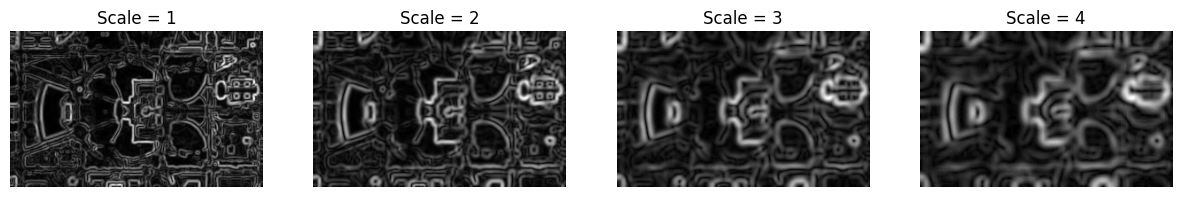

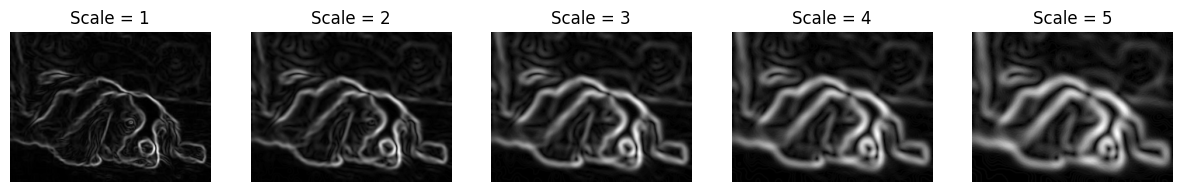

In [44]:
# 3. Multi-scale edge detection
def multi_scale_edge_detection(image_path: str, scales: List[int]) -> None:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(15, 5))
    
    for i, sigma in enumerate(scales):
        # Using Gaussian blur
        blurred = cv2.GaussianBlur(img, (0, 0), sigma)
        
        # Using Sobel edge detection
        grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
        edges = cv2.magnitude(grad_x, grad_y)
        
        # Plot the result
        plt.subplot(1, len(scales), i+1)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Scale = {sigma}')
        plt.axis('off')
    
    plt.show()

# Application
multi_scale_edge_detection('image1.jpeg', [1,2,3,4])
multi_scale_edge_detection('dog.jpeg', [1,2,3,4,5])